# Auto Différenciation

Voici une implementation simpliste d'un systeme d'auto-differentation (calcul automatique de derivees). l'API est largement inspirée du framework
pytorch.

Les algorithmes d'autodifférentiation ne repose que sur une règle: **La dérivation de fonction composée**.
Pour pouvoir automatiquement calculer les dérivées de n'importe quelle fonction, on va définir des fonctions élémentaires (l'addition, la multiplication, le log) et leur dérivées puis appliquer la formule de composition des dérivées avec ces fonctions élémentaires. 

Les éléments principaux sont du framework sont: 

- Les objets `Tensor` qui représentent les données dans le framework
- Les classes `Function` qui définissent les différentes opérations élémentaires applicables aux `Tensors`



## Classe Tensor

La classe `Tensor` est la pierre angulaire du système d'autodifférenciation. Elle instancie des tenseurs, des structures de données permettant aussi de stocker des gradients. 


In [693]:
from typing import Any, Callable, Sequence
from numpy import array, ndarray
from numpy.typing import  NDArray

type BackwardFunction =  Callable[[Sequence['Tensor'], 'Tensor'], list['Tensor']]
type TensorLike = Tensor | list[Any] | float | int | NDArray

class Tensor:
    """ Class Tensor pour mettre qui est la brique élémentaire du système d'autodiff"""

    @staticmethod
    def _broadcast_tensor(value: TensorLike) -> TensorLike:
        if isinstance(value, list):
            return array(value, dtype=float)
        if isinstance(value, int):
            return float(value)
        if isinstance(value, ndarray):
            return value.astype(float)
        return value
    
    def __len__(self):
        if isinstance(self.value, ndarray):
            return len(self.value)
        return 1

    def __init__(self, value: TensorLike, inputs: Sequence['Tensor'] = [], gradfn: BackwardFunction | None = None):
        """ initialisation d'un Tensor.
        
            args:
                - value(TensorLike): 
                    valeur du tenseur. accepte les memes entrées qu'un array numpy
                - inputs(Tensor[] = []):
                    les tenseurs dépendant de celui-ci pour l'autodiff. Il ne devraient pas 
                    être renseignées manuellement.
                - gradfn(BackwardFunction | None = None)
                    la dérivée de ce tenseur. Elle ne devrait pas être renseignée manuellement.
            """
        self.value = self._broadcast_tensor(value)
        self._inputs = inputs
        self._gradfn = gradfn
        self.grad: Tensor | None = None

    def __repr__(self):
        return f"tensor(value={self.value})"


    def backward(self, grad_output: 'Tensor | None' = None):
        """ permet de calculer les gradients des entrées de ce tenseur.
            Cette fonction ne doit être appelée qu'une fois depuis le tenseur parent.
            (ie: le tenseur qui contient le résultat de la fonction a deriver).
        """
        if grad_output is None:
            grad_output = self.__class__(1.)

        if self._gradfn is None:
            raise ValueError('gradient not provided. Run Forward before')           

        output = self._gradfn(self._inputs, grad_output)

        for index, input_ in enumerate(self._inputs): 
            if input_._gradfn:
                input_.backward(output[index])

    def zero_grad(self):
        self.grad = Tensor(0)


## Fonction pour Créer des Tenseurs

On définit aussi un wrapper sur le constructeur de la clase `Tensor` pour simplifier leur instanciation
Si `value` est déjà une instance de `Tensor`, la fonction renvoie simplement cette instance. Sinon, elle crée un nouveau tenseur en utilisant les paramètres fournis.

Cela permet une utilisation plus fluide et concise pour créer des tenseurs dans le système d'autodifférenciation.

In [694]:
def tensor(value: TensorLike, inputs: Sequence['Tensor'] = [], gradfn: BackwardFunction | None = None):
    if isinstance(value, Tensor):
        return value
    return Tensor(value=value, inputs=inputs, gradfn=gradfn)

# Classe MetaFunction et Classe Abstraite Function

La classe `MetaFunction` est une métaclasse qui simplifie permet d'appeler la méthode static `forward` des classes `Function` en les appelant, au lieu de les instancier. Cela permet d'économiser quelques lignes de code.

La classe `Function` est une classe abstraite qui définit les opérations élémentaires nécessaires à la backpropagation dans le système d'autodifférenciation. Elle permet de créer des opérations personnalisées en héritant de cette classe.

Voici les points clés de la classe `Function` :

- Les méthodes `_forward` et `_backward` doivent être surchargées dans les sous-classes pour définir respectivement le calcul d'une opération et son gradient.

- Les méthodes `forward` et `backward` fournissent un wrapper autour des méthodes précédemment citées. La méthode `forward` prend en charge le calcul de l'opération sur les entrées et crée un nouveau tenseur avec la valeur résultante. La méthode `backward` calcule les gradients et les propage aux tenseurs d'entrée.

En utilisant ces deux classes, on peut définir facilement de nouvelles opérations pour l'autodifférenciation dans le système.

In [695]:
class MetaFunction(type):
    """ Metaclass purement cosmetique, pour économiser quelques lignes de code
    en appelant directement les Function (voir ci-dessous) sur les tenseurs
    """
    def __call__(cls, *args, **kwargs):
        return cls.forward(*args, **kwargs) #type: ignore


class Function(metaclass=MetaFunction): 
    """ Class Abstraite Function
    
        Celles-ci permettent de définir les opérations élémentaires nécessaires à la 
        backpropagation

        Les methods _forward et _backward doivent être override pour definir respectivement
        le calcul d'une operation et son gradient.

        Les methods forward et backward fournissent un wrapper autour des methods citées ci-dessus.
    """    
    def __init__(self, *inputs: Tensor):
        raise ValueError("Functions are static classes which shouldn't be instanciated")
        ...   

    @staticmethod   
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        raise NotImplementedError('Function class needs to be inherited and implement _forward and _backward')

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        raise NotImplementedError('Function class needs to be inherited and implement _forward and _backward')

    @classmethod   
    def forward(cls, *inputs: Tensor) -> Tensor:
        return Tensor(
            value=cls._forward([input_.value for input_ in inputs]),
            gradfn=cls.backward,
            inputs=inputs
        ) 
        
    @classmethod
    def backward(cls, inputs: Sequence[Tensor], grad_output: Tensor) -> list[Tensor]:
        grad = cls._backward([input_.value for input_ in inputs], grad_output.value)
        tensor_grads = [] 
        for index, input_ in enumerate(inputs):
            if not input_.grad:
                input_.grad = Tensor(0.) 
            input_.grad.value += grad[index] #type: ignore
            tensor_grads.append(input_.grad)
        return tensor_grads
    


# Opérations d'Autodifférenciation

Dans cette section, des opérations d'autodifférenciation couramment utilisées sont définies sous forme de classes. Chaque classe hérite de la classe abstraite `Function` pour définir le comportement de l'opération.

Voici un aperçu des opérations et de leurs gradients :

- `Add` : Opération d'addition.
- `Mul` : Opération de multiplication.
- `Pow` : Opération de puissance (exposant).
- `Dot` : Opération de produit matriciel par vecteur.
- `Sum` : Opération de sommation d'un vecteur.
- `Log` : Opération de logarithme naturel.
- `Exp` : Opération d'exponentielle.
- `Neg` : Opération de négation.
- `Sub` : Opération de soustraction.
- `Div` : Opération de division.
- `ReLU` : Fonction d'activation ReLU.

Ces classes d'opérations servent de base pour construire des calculs plus complexes dans le système d'autodifférenciation. Elles sont utilisées pour définir comment les gradients sont calculés pour différentes opérations mathématiques.

In [696]:
from numpy import dot, exp, log, maximum, sum as np_sum, ones_like, outer, zeros_like

class Add(Function):
    """ Operation d'addition """
    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (x,y) => x + y """
        return inputs[0] + inputs[1] # type: ignore

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """d(x+y)/dx = 1 , d(x+y)/dy = 1 """
        return [grad_output, grad_output]
    
class Mul(Function):
    """ Operation de multiplication """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (x,y) => x*y """
        return inputs[0]*inputs[1]   # type: ignore

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """ d(x*y)/dx = y , d(x*y)/dy = x"""
        return [inputs[1]*grad_output, inputs[0]*grad_output]  # type: ignore
    
class Pow(Function):
    """ Operation de power (exposant) """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ x^y """
        return inputs[0]**inputs[1]  # type: ignore

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output) -> list[TensorLike]:
        """ d(x^y)/dx = y*x^(y-1) , d(x^y)/dy = ln(x)*x^y"""
        res = [
            grad_output*inputs[1]*inputs[0]**(inputs[1] - 1),  # type: ignore
            grad_output*log(maximum(inputs[0], 0))*inputs[0]**(inputs[1])  # type: ignore
         ]     
        return res    
    
class Dot(Function):
    """ Operation de produit Matrice x Vecteur"""

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (A, x) => Ax """
        return inputs[0] @ inputs[1] # type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """ d(Ax)/dA = x.T , d(Ax)/dx = A """
        return [    
            outer(grad_output, inputs[1]),  # type: ignore
            inputs[0].T @ grad_output # type: ignore
        ]
    
class Sum(Function):
    """ Operation de sommation d'un vecteur"""

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (x1,x2,x3,x4) => x1+x2+x3+x4"""
        return np_sum(inputs[0]) # type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """ d(sum(v))/dv = (1,1,1,1)"""
        return [
            ones_like(inputs[0]) * grad_output 
        ]
    
class Log(Function):
    """ Operation de Log"""

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (x) => ln(x)"""
        return maximum(log(inputs[0]), -100) #type: ignore

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """ d(log(x))/dx = 1/x"""
        return [
            grad_output/inputs[0] #type: ignore
        ]
    
class Exp(Function):

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        return exp(inputs[0]) #type: ignore

    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        return [
            grad_output*exp(inputs[0]) #type: ignore
        ]

class Neg(Function):
    """ negation """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        return - inputs[0] #type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        return [
            (-1)*ones_like(inputs[0])*grad_output #type: ignore
        ]
    
class Sub(Function):
    """ Soustraction """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        return inputs[0] - inputs[1] #type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        return [
            ones_like(inputs[0])*grad_output,  #type: ignore          
            (-1)*ones_like(inputs[1])*grad_output, #type: ignore            
        ]
    
class Div(Function):
    """ Division """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        return inputs[0]/inputs[1] #type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        return [
            grad_output/inputs[1], #type: ignore
            - grad_output*inputs[0]/(inputs[1]**2) #type: ignore
        ]

class ReLU(Function):
    """ Fonction relu (x) => max(0, x)

        On choisira relu'(0) = 0 (car relu non derivable en 0)
    """

    @staticmethod
    def _forward(inputs: list[TensorLike]) -> TensorLike:
        """ (x) => max(x, 0)"""
        return maximum(inputs[0], 0) #type: ignore
    
    @staticmethod
    def _backward(inputs: list[TensorLike], grad_output: TensorLike) -> list[TensorLike]:
        """ drelu(x)/dx = 0 si x <= 0 et 1 sinon"""
        res = zeros_like(inputs[0])
        res[inputs[0] > 0] = 1 #type: ignore
        return [
            res*grad_output            
        ]

# Surcharge des Opérateurs pour les Tenseurs

Pour effectuer plus explicitement les opérations entre `Tensor`, on surcharge les différents opérateurs. 
Ces surcharges facilitent l'expression des opérations mathématiques sur les tenseurs de manière naturelle et intuitive.

In [697]:
Tensor.__mul__ = lambda self, other: Mul(self, tensor(other))
Tensor.__rmul__ = lambda self, other: Mul(tensor(other), self)
Tensor.__add__ = lambda self, other: Add(self, tensor(other))
Tensor.__radd__ = lambda self, other: Add(tensor(other), self)
Tensor.__neg__ = lambda self: Neg(self)
Tensor.__truediv__ = lambda self, other: Div(self, tensor(other))
Tensor.__rtruediv__ = lambda self, other: Div(tensor(other), self)
Tensor.__sub__ = lambda self, other: Sub(self, tensor(other))
Tensor.__rsub__ = lambda self, other: Sub(tensor(other), self)
Tensor.__pow__ = lambda self, other: Pow(self, tensor(other))
Tensor.__rpow__ = lambda self, other: Pow(tensor(other), self)
Tensor.__matmul__ = lambda self, other: Dot(self, tensor(other))
Tensor.__rmatmul__ = lambda self, other: Dot(tensor(other), self)


# Fonctions Utilitaires

Dans la suite, on utilisera notre framework pour entrainer un regression logistique sur iris.
On définit alors les fonctions `binary_cross_entropy` (la loss que nous utiliserons). et `sigmoid` (pour transformer les sorties de la regression en logits).
On définit chacune de ces fonctions avec nos `Tensor` pour pouvoir les dériver automatiquement.

On implémente aussi une `accuracy` pour voir les scores que l'on obtient.

In [698]:
from numpy import mean

def binary_cross_entropy(y_prob_preds: Tensor, y_true: Tensor) -> Tensor:
    return (- 1/len(y_true))*Sum(y_true*Log(y_prob_preds) + (1 - y_true)*Log(1 - y_prob_preds)) # type: ignore

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + Exp(-x)) # type: ignore

def accuracy(y_true: NDArray, y_preds: NDArray): 
    return mean(y_true == y_preds)


# Exemple d'un Réseau de Neurones MLP avec des Activations ReLU

Dans cet exemple, nous créons un réseau de neurones à deux couches, notées A et B, avec des fonctions d'activation ReLU. La sortie de la couche B est ensuite passée à une fonction d'activation sigmoid, et les sorties sont sommées pour obtenir la valeur finale.

- `A` : La matrice de poids de la couche A.
- `B` : La matrice de poids de la couche B.
- `x` : Le vecteur d'entrée.
- `z` : La sortie du réseau de neurones.

Le calcul de `z` se déroule comme suit :
1. Le vecteur d'entrée `x` est propagé à travers la couche A en effectuant d'abord une multiplication matricielle avec A, puis en appliquant la fonction d'activation ReLU à chaque élément du résultat.
2. Le résultat de la couche A est ensuite propagé à travers la couche B de la même manière, en effectuant une multiplication matricielle avec B et en appliquant à nouveau la fonction d'activation ReLU.
3. Les sorties de la couche B sont ensuite passées à travers la fonction d'activation sigmoid pour obtenir des valeurs dans l'intervalle (0, 1).
4. Enfin, toutes les sorties sont sommées pour obtenir la valeur finale `z`.

Cet exemple illustre comment utiliser les opérations définies précédemment pour construire un réseau de neurones avec différentes couches et fonctions d'activation. La rétropropagation des gradients à travers ce réseau permettrait d'ajuster les poids pour l'apprentissage.

In [699]:
A = Tensor([[4., -2], [-1,2], [5,2]])
B = Tensor([[3,2,1], [1,-1,1], [-1, 0., 2]])
x = Tensor([2., -3])
z: Tensor = Sum(sigmoid(ReLU(B @ ReLU(A @ x)))) #type: ignore

In [700]:
z.backward()
print("z: ", z)
print("Gradient de A: ", A.grad)
print("Gradient de B: ", B.grad)

z:  tensor(value=2.4999999847700205)
Gradient de A:  tensor(value=[[ 3.04599586e-08 -4.56899378e-08]
 [ 0.00000000e+00  0.00000000e+00]
 [ 3.04599586e-08 -4.56899378e-08]])
Gradient de B:  tensor(value=[[1.47428643e-19 0.00000000e+00 4.21224694e-20]
 [2.13219710e-07 0.00000000e+00 6.09199171e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]])


# Régression Logistique

Pour tester notre framework, nous allons maintenant implémenter une régression logistique. 

In [701]:
# application a regression logistique
from numpy.random import normal

class LogisticRegression: 

    def __init__(self, input_size: int):
        self.weight = Tensor(normal(size=(1, input_size)))
        self.bias = Tensor(0.)

    def parameters(self):
        return self.weight, self.bias

    def __call__(self, x: Tensor):
        return sigmoid(self.weight @ x + self.bias) #type: ignore 
    
    def predict(self, X: NDArray, threshold = 0.5):
        return array([self(Tensor(x)).value[0] > threshold for x in X]) #type: ignore

# Optimisation

On définit aussi une classe d'optimisateur par la descente de gradient avec pas constant. Comme notre exemple est très simple, on tel optimisateur suffira.

In [702]:
class GradientOptimizer: 

    def __init__(self, parameters: Sequence[Tensor], lr: float = 1e-4):
        self.parameters = parameters
        self.lr = lr

    def step(self):
        for param in self.parameters:
            if param.grad is not None:
                param.value -= self.lr * param.grad.value # type: ignore

    def zero_grad(self):
        # Réinitialise les gradients de tous les paramètres à zéro
        for param in self.parameters:
            if param.grad is not None:
                param.zero_grad()


# Chargement du Jeu de Données Iris en Classification Binaire

Dans cette section, nous chargeons le célèbre jeu de données Iris à partir de la bibliothèque scikit-learn (sklearn). Cependant, nous transformons ce jeu de données en un problème de classification binaire en supprimant toutes les instances de la classe 2. Ensuite, nous effectuons une permutation aléatoire des données pour mélanger l'ordre des échantillons.

Le résultat de cette transformation est stocké dans les tableaux NumPy `X` et `Y`. 
- `X` contient les caractéristiques des échantillons.
- `Y` contient les étiquettes de classe correspondantes (0 ou 1) pour la classification binaire.


In [703]:
from sklearn import datasets
import numpy as np

def load_binary_iris():
    iris = datasets.load_iris()
    X = iris['data']
    y = iris['target']
    y = y[~(y == 2)]
    shuffle = np.random.permutation(len(y))
    return X[shuffle],y[shuffle] 

X, Y = load_binary_iris()
Y

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0])

# Création du Modèle de Régression Logistique et Entraînement

On instancie un model de régression logistique ainsi qu'un optimisateur, auquel on attache les parametres de la régression.

In [704]:
log_reg = LogisticRegression(input_size=4)
optim = GradientOptimizer(log_reg.parameters(), lr=1e-2)
print("Avant entrainement: ")
print("Accuracy: ", accuracy(log_reg.predict(X), Y))
# environ 0.5 car le jeu de donnees est equilibre

Avant entrainement: 
Accuracy:  0.5


# Entraînement du Modèle de Régression Logistique

Dans cette section, nous définissons une fonction `train` qui prend en entrée un modèle de régression logistique (`model`), les données d'entraînement (`X` et `Y`), et effectue l'entraînement du modèle.

- `train(model: LogisticRegression, X ,Y)` : Cette fonction parcourt les données d'entraînement en utilisant une boucle `for`. Pour chaque échantillon `x` et son étiquette de classe correspondante `y`, elle effectue les étapes suivantes :
  1. Transforme `x` et `y` en tenseurs (`Tensor(x)` et `Tensor(y)`).
  2. Réinitialise les gradients de tous les paramètres du modèle à zéro en utilisant `optim.zero_grad()`.
  3. Utilise le modèle pour faire des prédictions `y_preds` sur `x`.
  4. Calcule la perte binaire (entropie croisée) entre les prédictions `y_preds` et l'étiquette de classe réelle `y`.
  5. Effectue la rétropropagation des gradients pour calculer les gradients par rapport aux paramètres du modèle en utilisant `loss.backward()`.
  6. Met à jour les paramètres du modèle en utilisant l'optimiseur avec `optim.step()`.

Ce processus permet au modèle d'apprendre à partir des données d'entraînement et d'ajuster ses paramètres pour minimiser la perte, ce qui améliore sa capacité à effectuer des prédictions précises.

In [705]:
def train(model: LogisticRegression, X ,Y):
    for index, (x,y) in enumerate(zip(X,Y)):
        x = Tensor(x)
        y = Tensor(y)
        optim.zero_grad()
        y_preds = model(x)
        loss = binary_cross_entropy(y_preds, y)
        loss.backward()
        optim.step()

        if index % 20 == 0:
            print('loss: ', loss)

train(log_reg, X, Y)

loss:  tensor(value=0.0013672891511811948)
loss:  tensor(value=0.914007456335607)
loss:  tensor(value=0.09458624352179655)
loss:  tensor(value=0.9043151819906351)
loss:  tensor(value=0.5423726686021525)


In [706]:
print("Apres entrainement: ")
print("Accuracy: ", accuracy(log_reg.predict(X), Y))

Apres entrainement: 
Accuracy:  1.0


# Visualisation des Prédictions du Modèle

On a une bonne `accuracy` avec le model. On va plot les points pour voir nos résultats


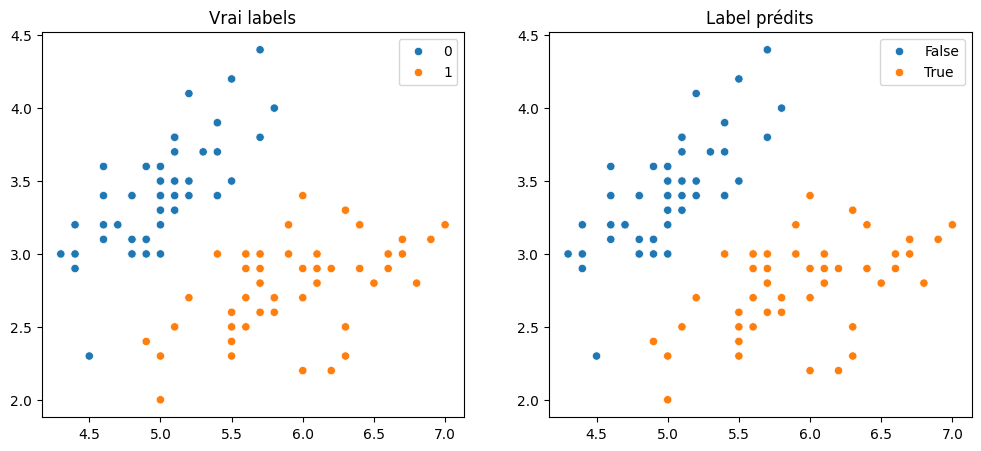

In [707]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model(model: LogisticRegression, X, Y):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(x=X[:,0], y=X[:, 1], hue=Y, ax=axes[0])
    sns.scatterplot(x=X[:,0], y=X[:, 1], hue=model.predict(X), ax=axes[1])
    axes[0].set_title('Vrai labels')
    axes[1].set_title("Label prédits")

plot_model(log_reg, X, Y)